In [1]:
import signal_generator as sg
import pandas as pd
import polars as pl
import os
import numpy as np
import plotly.express as px
from typing import List

import data_processor as dp
import base_trainer as bt
import custom_plotting 

Preprocess data and create features and targets using data_processor.py

In [7]:
TICKER_DATA_PATH = r"..\..\data\ticker_specific_data_BINANCE"
pairs = pd.read_csv(r"pairs.csv") 
NUM_PAIRS_TO_LOAD = 100
pairs = pairs.iloc[:NUM_PAIRS_TO_LOAD, 0].values
pairs = [pair.replace("USD", "USDT") for pair in pairs]
pair = pairs[2]
df = pl.read_parquet(f'{TICKER_DATA_PATH}/{pair.replace("/", "")}.parquet').to_pandas()

df

,Date,open,high,low,close,volume,usd_volume
0,2022-01-01 00:00:00,0.8298,0.8364,0.8297,0.8336,3414487.0,2.846316e+06
1,2022-01-01 00:30:00,0.8335,0.8400,0.8331,0.8395,2741913.0,2.301836e+06
2,2022-01-01 01:00:00,0.8396,0.8528,0.8320,0.8437,11518898.0,9.718494e+06
3,2022-01-01 01:30:00,0.8438,0.8460,0.8382,0.8396,4393928.0,3.689142e+06
4,2022-01-01 02:00:00,0.8396,0.8432,0.8392,0.8423,2340925.0,1.971761e+06
...,...,...,...,...,...,...,...
54316,2025-02-03 09:00:00,2.3616,2.4100,2.3518,2.3832,20908852.0,4.982998e+07
54317,2025-02-03 09:30:00,2.3833,2.4015,2.3602,2.3733,15562632.0,3.693479e+07
54318,2025-02-03 10:00:00,2.3735,2.3929,2.3343,2.3668,14496478.0,3.431026e+07
54319,2025-02-03 10:30:00,2.3669,2.4405,2.3650,2.4320,15101241.0,3.672622e+07


In [8]:
df['Date']

0       2022-01-01 00:00:00
1       2022-01-01 00:30:00
2       2022-01-01 01:00:00
3       2022-01-01 01:30:00
4       2022-01-01 02:00:00
                ...        
54316   2025-02-03 09:00:00
54317   2025-02-03 09:30:00
54318   2025-02-03 10:00:00
54319   2025-02-03 10:30:00
54320   2025-02-03 11:00:00
Name: Date, Length: 54321, dtype: datetime64[ns]

In [9]:
feature_df, feature_names = dp.create_feature_dataset(df)
target_df, target_names = dp.create_target_dataset(df, target_type='regression')

In [136]:
feature_df = feature_df.loc[:, feature_names + ['Date']]

In [138]:
target_df

,target_regr_horizon1,target_regr_horizon6,target_regr_horizon12,target_regr_horizon24,target_regr_horizon48,Date
0,0.007078,0.010317,0.009477,0.008877,0.012356,2022-01-01 00:00:00
1,0.005003,0.001787,-0.002144,0.003574,0.007743,2022-01-01 00:30:00
2,-0.004860,-0.007112,-0.006519,-0.001185,-0.001067,2022-01-01 01:00:00
3,0.003216,-0.005955,0.001906,0.001548,0.003335,2022-01-01 01:30:00
4,0.000237,0.001900,-0.001306,0.000594,-0.000475,2022-01-01 02:00:00
...,...,...,...,...,...,...
54316,-0.004154,NaN,NaN,NaN,NaN,2025-02-03 09:00:00
54317,-0.002739,NaN,NaN,NaN,NaN,2025-02-03 09:30:00
54318,0.027548,NaN,NaN,NaN,NaN,2025-02-03 10:00:00
54319,-0.006867,NaN,NaN,NaN,NaN,2025-02-03 10:30:00


Define model names and initialize models

In [13]:
model_names = ['ridge_regression', 'linear_regression']
models_dict = {}
model_args = {'ridge_regression': {'alpha': 0.5}, 'linear_regression': {}}

for model_name in model_names:
    models_dict[model_name] = bt.get_model(model_name=model_name, **model_args[model_name]) # creates instances of BaseModel classes from base_trainer.py
    assert isinstance(models_dict[model_name], bt.BaseModel), "Not of type BaseModel!"

Train and Evaluate Models

In [15]:
eval_date = pd.to_datetime('2024-01-01')
train_date = pd.to_datetime('2022-04-01')

Xtrain = feature_df.loc[(train_date <= feature_df.index) &  (feature_df.index < eval_date)].loc[:, feature_names]
Xtest = feature_df.loc[feature_df.index >= eval_date].loc[:, feature_names]
ytrain = target_df.loc[(train_date <= target_df.index) &  (target_df.index < eval_date)].loc[:, ['target_regr_horizon6']]
ytest = target_df.loc[target_df.index >= eval_date].loc[:, ['target_regr_horizon6']]

# intialize Trainer class
"""
trainer_dict = {}
for model_name in model_names:
    trainer_dict[model_name] = bt.ModelTrainer(model_name, Xtrain, ytrain, Xtest, ytest)
"""

ridge_trainer = bt.ModelTrainer(models_dict['ridge_regression'], Xtrain, ytrain, Xtest, ytest)

In [16]:
ridge_trainer.train()

preds = ridge_trainer.model.predict(Xtest)

C:\Users\Damja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.15497e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [27]:
preds

array([[-2.02002692e-04],
       [ 6.81789527e-06],
       [-3.88457849e-04],
       ...,
       [-1.05143356e-02],
       [-8.72122710e-03],
       [-1.07904361e-02]])

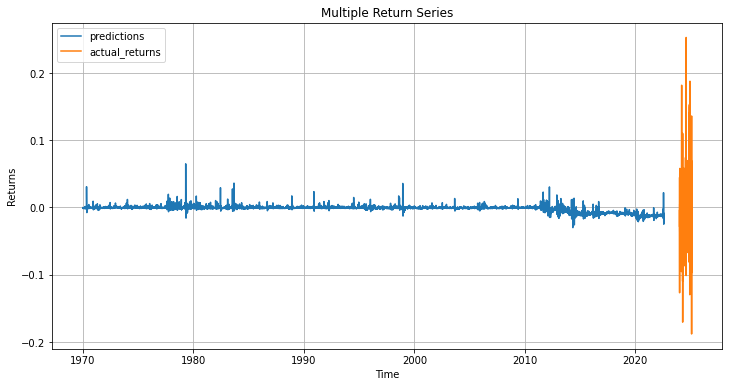

In [29]:
custom_plotting.plot_multiple_returns({'predictions': preds, 'actual_returns': ytest})

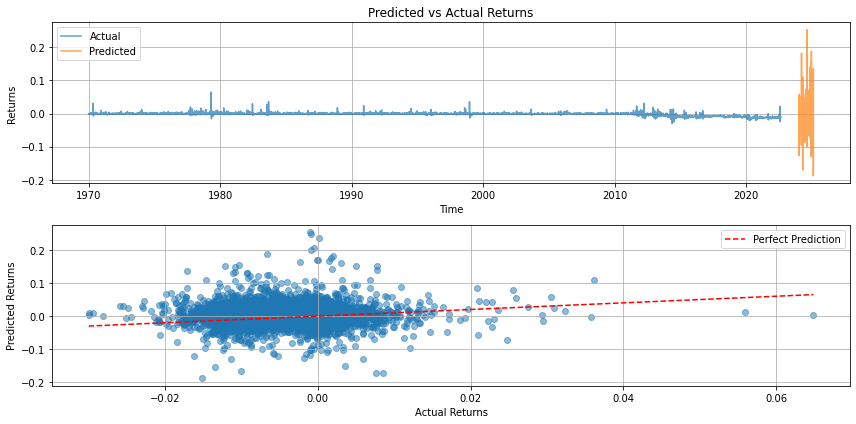

In [23]:
custom_plotting.plot_predicted_vs_actual(preds, ytest)

In [30]:
(preds > 0.01).sum()

77

In [31]:
(preds < 0.01).sum()

19136

In [32]:
(ytest > 0.01).sum()

target_regr_horizon6    3029
dtype: int64

In [33]:
(ytest < 0.01).sum()

target_regr_horizon6    16178
dtype: int64

In [36]:
px.line(ytest[(preds > 0.005)].values)

In [37]:
px.line(ytest[(preds < 0.005)].values)

In [1]:
## test signal generator and data processor

In [1]:
import feature_generator as fg
import pandas as pd
import polars as pl
import os
import numpy as np
import plotly.express as px
from typing import List, Dict, Tuple

import data_processor as datproc

In [5]:
TICKER_DATA_PATH = r"..\..\data\ticker_specific_data_BINANCE"
pairs = pd.read_csv(r"pairs.csv") 
NUM_PAIRS_TO_LOAD = 100
pairs = pairs.iloc[:NUM_PAIRS_TO_LOAD, 0].values
pairs = [pair.replace("USD", "USDT") for pair in pairs]

pairs = [p for p in pairs if p != 'USDTT/USDT']

In [7]:
dataclass = datproc.DataClass(pairs=pairs[0:15], input_path=TICKER_DATA_PATH)


In [8]:
dataclass.data_dict.keys()

dict_keys(['BTC/USDT', 'PEPE/USDT', 'XRP/USDT', 'WIF/USDT', 'DOGE/USDT', 'SOL/USDT', 'EUR/USDT', 'TURBO/USDT', 'ETH/USDT', 'SUI/USDT', 'XLM/USDT', 'WOO/USDT', 'NEAR/USDT', 'FTM/USDT', 'SHIB/USDT'])

In [9]:
dataclass.data_dict['BTC/USDT']


,open,high,low,close,volume,usd_volume,return_30m,return_1h,return_6h,volatility_2,...,RSI,RSI_feature,EMA_short,EMA_long,EMA_feature,BB_middle,BB_std,BB_upper,BB_lower,BB_feature
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,46216.93,46527.26,46208.37,46375.42,706.65682,3.277151e+07,NaN,NaN,NaN,NaN,...,NaN,0,46375.420000,46375.420000,-1,NaN,NaN,NaN,NaN,0
2022-01-01 00:30:00,46375.42,46731.39,46360.19,46656.13,796.67413,3.716973e+07,0.006053,NaN,NaN,NaN,...,NaN,0,46531.370000,46522.458571,1,NaN,NaN,NaN,NaN,0
2022-01-01 01:00:00,46656.14,46949.99,46574.06,46815.33,589.50801,2.759801e+07,0.003412,0.009486,NaN,0.001867,...,NaN,0,46647.747049,46629.520332,1,NaN,NaN,NaN,NaN,0
2022-01-01 01:30:00,46815.34,46884.63,46711.90,46778.14,354.30738,1.657384e+07,-0.000794,0.002615,NaN,0.002975,...,NaN,0,46691.918103,46672.143211,1,NaN,NaN,NaN,NaN,0
2022-01-01 02:00:00,46778.14,46928.94,46769.95,46826.01,273.51826,1.280777e+07,0.001023,0.000228,NaN,0.001285,...,NaN,0,46731.807411,46709.042912,1,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-03 09:00:00,95339.99,95950.68,95264.30,95880.57,1296.58328,1.243171e+08,0.005670,0.005139,0.015297,0.004383,...,64.062698,0,94964.688487,95187.550804,-1,94712.5510,1312.958704,97338.468407,92086.633593,0
2025-02-03 09:30:00,95880.58,95926.00,95222.03,95277.00,799.25512,7.615063e+07,-0.006295,-0.000661,0.013168,0.008460,...,61.599413,0,95027.150790,95195.682549,-1,94591.3715,1120.382613,96832.136725,92350.606275,0
2025-02-03 10:00:00,95277.00,95428.58,94799.29,95059.99,785.08692,7.463035e+07,-0.002278,-0.008558,0.018286,0.002841,...,54.641160,0,95033.718632,95183.346863,-1,94490.6710,965.271546,96421.214092,92560.127908,0


In [12]:
dataclass.data_dict['BTC/USDT']['volume_rel_ma24']

Date
2022-01-01 00:00:00         NaN
2022-01-01 00:30:00         NaN
2022-01-01 01:00:00         NaN
2022-01-01 01:30:00         NaN
2022-01-01 02:00:00         NaN
                         ...   
2025-02-03 09:00:00    0.669026
2025-02-03 09:30:00    0.413890
2025-02-03 10:00:00    0.405486
2025-02-03 10:30:00    0.277885
2025-02-03 11:00:00    0.034291
Name: volume_rel_ma24, Length: 54321, dtype: float64

In [15]:
px.line(dataclass.data_dict['XRP/USDT']['volume_rel_ma24'].dropna())

In [ ]:
# given normalized cross_sectional_feat_dict, can create first easy scoring,
